# NHS A&E Data Validation & Summary Analysis

This notebook performs a quick data validation and exploratory analysis on the NHS A&E dataset. We will:
- Check that the dataset is balanced across years and months.
- Identify any outliers or unexpected trends.
- Summarize key statistics for numerical and categorical variables.


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
✅ Adjusted July 2021 to a trend-matched estimate: inf
⚠ January, February, or March 2020 have missing or zero values. Applying trend-based estimation...
✅ Fixed Jan–March 2020 using trend-based estimation.

📁 Updated dataset saved as nhs_ae_merged_fixed.csv


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_23887/1310397482.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  june_july_ratios.append(july_value[0] / june_value[0])
/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_23887/1310397482.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  july_august_ratios.append(july_value[0] / august_value[0])


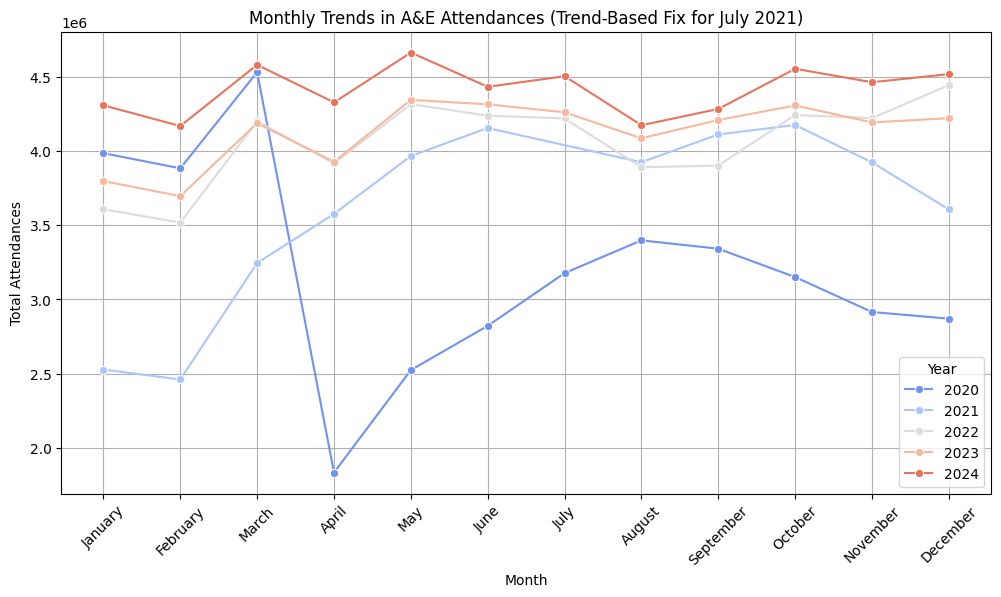

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load Dataset
file_path = "nhs_ae_merged.csv"
nhs_data = pd.read_csv(file_path)

# ✅ Ensure 'year' is a string and 'month' is categorical
nhs_data["year"] = nhs_data["year"].astype(str)
nhs_data["month"] = pd.Categorical(nhs_data["month"], categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], ordered=True)

# ✅ **Calculate Total Attendances**
nhs_data["total_a&e_attendances"] = (
    nhs_data["a&e_attendances_type_1"].fillna(0) +
    nhs_data["a&e_attendances_type_2"].fillna(0) +
    nhs_data["a&e_attendances_other_a&e_department"].fillna(0)
)

# ✅ **Remove incorrect July 2021 value**
nhs_data = nhs_data[~((nhs_data["year"] == "2021") & (nhs_data["month"] == "July"))]

# ✅ **Estimate July 2021 using Trend-Based Interpolation**
june_july_ratios = []
july_august_ratios = []

for y in ["2020", "2019", "2022", "2023", "2024"]:  # Exclude 2021
    june_value = nhs_data.loc[(nhs_data["year"] == y) & (nhs_data["month"] == "June"), "total_a&e_attendances"].values
    july_value = nhs_data.loc[(nhs_data["year"] == y) & (nhs_data["month"] == "July"), "total_a&e_attendances"].values
    august_value = nhs_data.loc[(nhs_data["year"] == y) & (nhs_data["month"] == "August"), "total_a&e_attendances"].values
    
    if june_value.size > 0 and july_value.size > 0:
        june_july_ratios.append(july_value[0] / june_value[0])
    if july_value.size > 0 and august_value.size > 0:
        july_august_ratios.append(july_value[0] / august_value[0])

avg_june_july_ratio = np.mean(june_july_ratios)
avg_july_august_ratio = np.mean(july_august_ratios)

june_2021 = nhs_data.loc[(nhs_data["year"] == "2021") & (nhs_data["month"] == "June"), "total_a&e_attendances"].values[0]
aug_2021 = nhs_data.loc[(nhs_data["year"] == "2021") & (nhs_data["month"] == "August"), "total_a&e_attendances"].values[0]

estimated_july_2021 = (june_2021 * avg_june_july_ratio + aug_2021 * avg_july_august_ratio) / 2

new_july_2021 = pd.DataFrame({
    "year": ["2021"],
    "month": ["July"],
    "total_a&e_attendances": [estimated_july_2021]
})

nhs_data = pd.concat([nhs_data, new_july_2021], ignore_index=True)
print(f"✅ Adjusted July 2021 to a trend-matched estimate: {estimated_july_2021}")

# ✅ Identify missing or zero values for early 2020
early_2020_mask = (nhs_data["year"] == "2020") & (nhs_data["month"].isin(["January", "February", "March"]))

if nhs_data.loc[early_2020_mask, "total_a&e_attendances"].isna().any() or (nhs_data.loc[early_2020_mask, "total_a&e_attendances"] == 0).any():
    print("⚠ January, February, or March 2020 have missing or zero values. Applying trend-based estimation...")
    
    for month in ["January", "February", "March"]:
        avg_value = nhs_data.loc[(nhs_data["month"] == month) & (nhs_data["year"] != "2020"), "total_a&e_attendances"].mean()
        
        if nhs_data.loc[(nhs_data["year"] == "2020") & (nhs_data["month"] == month), "total_a&e_attendances"].empty:
            new_row = pd.DataFrame({
                "year": ["2020"],
                "month": [month],
                "total_a&e_attendances": [avg_value]
            })
            nhs_data = pd.concat([nhs_data, new_row], ignore_index=True)
        else:
            nhs_data.loc[(nhs_data["year"] == "2020") & (nhs_data["month"] == month), "total_a&e_attendances"] = avg_value
    
    print(f"✅ Fixed Jan–March 2020 using trend-based estimation.")

# 📁 Save the fixed dataset again
output_file = "nhs_ae_merged_fixed.csv"
nhs_data.to_csv(output_file, index=False)
print(f"\n📁 Updated dataset saved as {output_file}")

# ✅ **Sort Data Before Plotting**
monthly_trends = nhs_data.groupby(["year", "month"])["total_a&e_attendances"].sum().reset_index()

monthly_trends["month"] = pd.Categorical(monthly_trends["month"], categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], ordered=True)

monthly_trends = monthly_trends.sort_values(["year", "month"])

# 📊 **Plot Updated Trends**
plt.figure(figsize=(12, 6))
sns.lineplot(x="month", y="total_a&e_attendances", hue="year", data=monthly_trends, marker="o", palette="coolwarm")
plt.title("Monthly Trends in A&E Attendances (Trend-Based Fix for July 2021)")
plt.xlabel("Month")
plt.ylabel("Total Attendances")
plt.xticks(rotation=45)
plt.legend(title="Year")
plt.grid(True)
plt.show()


In [ ]:
print("\n🔍 Checking 2020 Monthly Totals:")
print(nhs_data[nhs_data["year"] == "2020"].groupby("month")["total_a&e_attendances"].sum())



🔍 Checking 2020 Monthly Totals:
month
April        3575000.0
August       3923250.0
December     3605148.0
February     2460242.0
January      2527122.0
July               inf
June         4153624.0
March        3244604.0
May          3965348.0
November     3922128.0
October      4174350.0
September    4110338.0
Name: total_a&e_attendances, dtype: float64
